In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_text
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("../data/jamb_exam_results.csv")
df.shape

(5000, 17)

# Data Preparation

In [3]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [4]:
df.drop('student_id',axis=1, inplace=True)

In [5]:
df.isnull().sum().to_frame().rename(columns={0:'missing_values'}).merge(
    df.dtypes.to_frame().rename(columns={0:'dtypes'}), left_index=True,
    right_index=True)

,missing_values,dtypes
jamb_score,0,int64
study_hours_per_week,0,int64
attendance_rate,0,int64
teacher_quality,0,int64
distance_to_school,0,float64
school_type,0,object
school_location,0,object
extra_tutorials,0,object
access_to_learning_materials,0,object
parent_involvement,0,object


In [6]:
for col in df.columns:
    if df[col].isnull().sum() > 0:
        print(f"Filling missing values for: {col}")
        df[col] = df[col].fillna(0)

Filling missing values for: parent_education_level


In [7]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

len(df_train), len(df_val), len(df_test)

(3000, 1000, 1000)

In [8]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.jamb_score.values
y_val = df_val.jamb_score.values
y_test = df_test.jamb_score.values

del df_train['jamb_score']
del df_val['jamb_score']
del df_test['jamb_score']

# Question 1

In [9]:
def prepare_data(df_train):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=True)
    X_train = dv.fit_transform(dicts)
    
    return X_train, dv

In [10]:
X_train, dv = prepare_data(df_train)
X_valid = dv.transform(df_val.to_dict(orient='records'))

In [11]:
tree = DecisionTreeRegressor(max_depth=1)
tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [12]:
print(export_text(tree, feature_names=list(dv.get_feature_names_out())))


|--- study_hours_per_week <= 18.50
|   |--- value: [155.24]
|--- study_hours_per_week >  18.50
|   |--- value: [188.59]



# Question 2

In [13]:
params = {'n_estimators':10,
          'random_state':1,
          'n_jobs':-1 }

In [14]:
rf = RandomForestRegressor(**params)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [15]:
y_pred = rf.predict(X_valid)
root_mean_squared_error(y_val, y_pred).round(3)

42.137

# Question 3

In [16]:
scores = []
n_estimators = np.arange(10, 210, 10)
for n in n_estimators:
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_valid)
    rmse = root_mean_squared_error(y_val, y_pred).round(3)
    scores.append((n, rmse))
    if n % 20 == 0:
        print(f"Completed process for n_estimators: {n}")
rmse_df = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

Completed process for n_estimators: 20
Completed process for n_estimators: 40
Completed process for n_estimators: 60
Completed process for n_estimators: 80
Completed process for n_estimators: 100
Completed process for n_estimators: 120
Completed process for n_estimators: 140
Completed process for n_estimators: 160
Completed process for n_estimators: 180
Completed process for n_estimators: 200


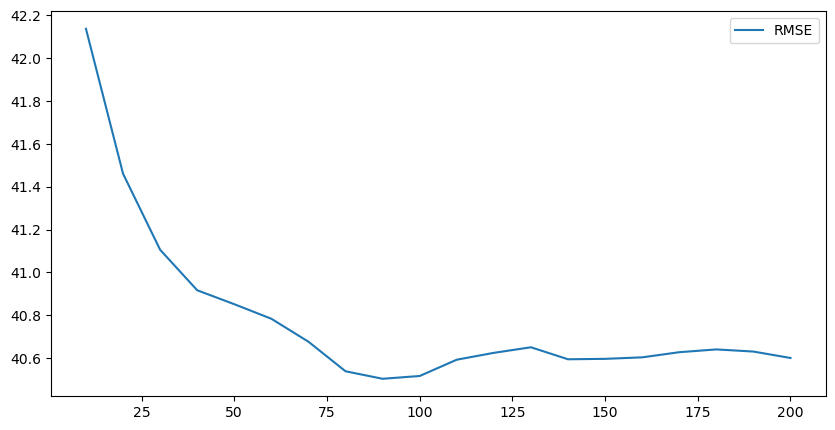

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(rmse_df.n_estimators, rmse_df.rmse, label='RMSE')
plt.legend()
plt.show()

In [18]:
rmse_df.iloc[rmse_df['rmse'].idxmin()]

n_estimators    90.000
rmse            40.504
Name: 8, dtype: float64

# Question 4

,n_estimators,rmse
0,10,42.137
1,20,41.461
2,30,41.106
3,40,40.917
4,50,40.852
5,60,40.784
6,70,40.677
7,80,40.539
8,90,40.504
9,100,40.517
